# 0.1 imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from sklearn.metrics import mean_squared_error, mean_absolute_error

# 0.2 helpers functions

In [4]:
# def plot_gdp(dataframe, countrys, print_legend=True):
    
#     countrys_with_year = countrys + ['year']
#     df=dataframe[countrys_with_year].copy()
#     # Create a list of colors
#     color_discrete_sequence = [
#         'navy', 'orange', 'tomato', 'crimson', 'darkgreen', 'brown',
#         'forestgreen', 'steelblue',
#     ]

#     # Create a list of traces
#     traces = []
#     for j, seleccion in enumerate(countrys):
#         trace = go.Scatter(
#             x=df['year'],
#             y=df[seleccion],
#             mode='lines+markers',
#             name=seleccion,
#             marker=dict(color=color_discrete_sequence[j % len(color_discrete_sequence)]),
#         )
#         traces.append(trace)

#     # Create the figure
#     fig = go.Figure(traces)

#     # Configure the layout
#     fig.update_layout(
#         title='GDP',
#         title_font_size=30,
#         plot_bgcolor='#F7FAFC',
#         xaxis=dict(tickangle=30),
#         yaxis=dict(tickformat=',.0f'),
#         xaxis_dtick='2',
#         xaxis_title='Year',
#         yaxis_title='Real GDP growth (Annual percent change)',
#         legend_title_text='Legend',
#         legend=dict(x=0, y=1) if print_legend == True else {},
#         showlegend=True if print_legend == True else False,
#         margin=dict(l=0, r=0, t=50, b=0),
#         template='plotly',
#         height=800,
#         width=1200,
#     )

#     return fig


In [5]:
def plot_gdp(dataframe, countrys, print_legend=True):
    countrys_with_year = countrys + ['year']
    df = dataframe[countrys_with_year].copy()

    color_palette = [
        'navy', 'orange', 'tomato', 'crimson', 'darkgreen', 'brown',
        'forestgreen', 'steelblue',
    ]
    
    plt.figure(figsize=(12, 8))

    for seleccion in countrys:
        sns.lineplot(x='year', y=seleccion, data=df, label=seleccion)#, color=color_palette[j % len(color_palette)])

    plt.title('GDP', fontsize=20)
    plt.xlabel('Year')
    plt.ylabel('Real GDP growth (Annual percent change)')
    plt.xticks(rotation=30)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
    
    if print_legend:
        plt.legend(title='Legend', loc='upper left')
    else:
        plt.legend().set_visible(False)
    
    plt.tight_layout()
    plt.grid()
    plt.show()

In [6]:

def fill_individual_countries(dataframe, countries):
    
    df = dataframe[countries+['year']].copy()

    check_na = df.isna().sum()
    null_values = list(check_na[check_na>0].index)

    complete_group = list(check_na[check_na==0].index)
    complete_group.remove('year')
    # complete_group.remove('Sub-Saharan Africa (Region) ')

    df_complete_group = dataframe[complete_group]

    df_aux = pd.DataFrame()

    df_aux["year"] = dataframe["year"]
    df_aux["year_average"] = df_complete_group.mean(axis=1)


    for country in null_values:

        df_aux[country] = dataframe[country]

        aux = df_aux[~df_aux[country].isna()]

        aux['test'] = (aux[country] > aux['year_average']).astype(int)


        most_common = aux['test'].value_counts().idxmax()

        if most_common == 0:
            df_aux.loc[df_aux[country].isna(), country] = df_aux.loc[df_aux[country].isna(), "year_average"] - df_aux[country].std()
        else:
            df_aux.loc[df_aux[country].isna(), country] = df_aux.loc[df_aux[country].isna(), "year_average"] + df_aux[country].std()

    return df_aux

In [7]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:

def metrics(y_true, y_pred,model_name):
    y_true = y_true.values
    y_pred = y_pred.values
    mae = round(mean_absolute_error(y_true, y_pred),5)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),5)
    mape = round(mean_absolute_percentage_error(y_true, y_pred),5)
    metrics = pd.DataFrame({'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape}, index=[0])
    return metrics



# 0.3 load data

In [9]:
path = '/home/lavino/Documentos/projetos_indicium/ds_desafio/'

In [10]:
df_raw = pd.read_csv(path + 'data/df_fill.csv', index_col='year', parse_dates=True)
df_raw.shape

(49, 228)

In [11]:
df_raw = df_raw.asfreq(freq='AS')

## 0.4 métricas de avaliação

Para este projeto será utilizadas três métricas de avaliação:

- MAE (Erro Médio Absoluto):
    O Erro Médio Absoluto (MAE) é uma métrica simples e intuitiva que mede a média das diferenças absolutas entre as previsões e os valores reais. Em outras palavras, ele calcula o tamanho médio dos erros de previsão sem considerar sua direção. O MAE é útil quando você deseja entender o tamanho médio dos erros de previsão em unidades originais. Ele não é sensível a outliers e é fácil de interpretar.

- RMSE (Raiz do Erro Quadrático Médio):
    O Erro Quadrático Médio (RMSE) é uma métrica que mede a raiz quadrada da média dos erros ao quadrado entre as previsões e os valores reais. O RMSE penaliza erros maiores mais do que erros menores devido à natureza quadrática do cálculo. Ele fornece uma ideia da dispersão dos erros e é mais sensível a outliers do que o MAE. O RMSE é útil quando você deseja ter uma noção da variação dos erros.

- MAPE (Erro Percentual Médio Absoluto):
    O Erro Percentual Médio Absoluto (MAPE) é uma métrica que mede a média das porcentagens absolutas dos erros em relação aos valores reais. Ele expressa os erros relativos como uma porcentagem do valor real, tornando-o útil para entender a precisão relativa do modelo em diferentes escalas de valores. No entanto, o MAPE pode ser problemático quando os valores reais são muito próximos de zero, pois isso pode levar a divisões por zero ou valores extremamente altos.

Sendo o MAE como métrica principal e o RMSE e MAPE como métricas secundárias.

# 1.0 Season decomposition - additive model

Foi feito inicialmente o teste com países aléatorios, mas em seguida todos os gráficos de decomposição foram plotados e salvos na pasta `images`

In [12]:
# country = 'Albania'
# country = 'Sub-Saharan Africa (Region) '
# country = 'Argentina'
country = 'United States'

## 1.1 plot

/tmp/ipykernel_38529/4242940995.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]);


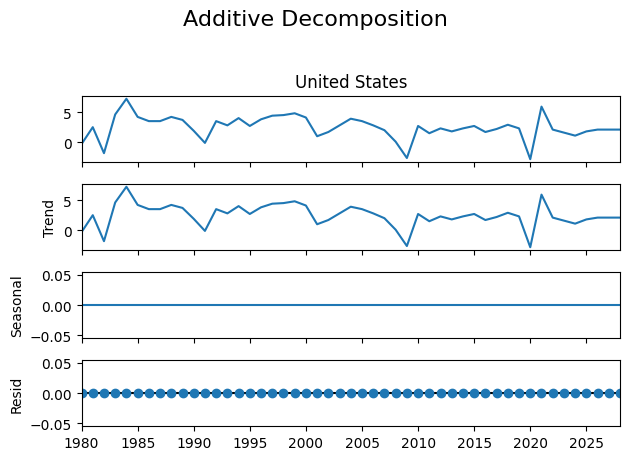

In [13]:
decomposition = seasonal_decompose(
    df_raw[country], 
    model='additive',
)

decomposition.plot().suptitle('Additive Decomposition', fontsize=16);
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [14]:
# # Criar a pasta 'images' se ela ainda não existir
# if not os.path.exists(path + 'images'):
#     os.makedirs('images')

# # Iterar através dos países
# for country in df_raw.columns:
#     # Filtrar os dados para o país atual
#     country_data = df_raw[country]
    
#     # Realizar a decomposição sazonal
#     decomposition = seasonal_decompose(country_data, model='additive')
    
#     # Plotar e salvar a imagem
#     plt.figure(figsize=(10, 6))
#     decomposition.plot()
#     plt.suptitle(f'Additive Decomposition for {country}', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(path + f'images/{country}_decomposition.png')
#     plt.close()  # Fechar a figura para liberar memória


## 1.2 adf test

Teste estátisco para descobrir se a série é estacionária ou não.

In [15]:
stacionary_data = []
non_stacionary_data = []

for series in df_raw.columns:

    country_data = df_raw[[series]]

    # Realizando o teste ADF
    result = adfuller(country_data)

    # Interpretando os resultados do teste
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])

    if result[1] <= 0.05:
        # print("A série é estacionária.")
        stacionary_data.append(series)
    else:
        # print("A série não é estacionária.")
        non_stacionary_data.append(series)


In [16]:
print("% das series temporais estácionárias:",(len(stacionary_data)/len(df_raw.columns)*100))
print("% das series temporais não estácionárias:",(len(non_stacionary_data)/len(df_raw.columns)*100))

% das series temporais estácionárias: 81.14035087719299
% das series temporais não estácionárias: 18.859649122807017


In [17]:
len(non_stacionary_data)

43

Devido a natureza dos dados economicos toodas as series serão consideradas estacionarias, sem sazonalidade e tendência definidas

# 2.0 Models

In [18]:
df1 = df_raw.copy()

## 2.1 test train split

In [19]:
test_years = 5
train = df1[:-test_years]
test = df1[-test_years:]

## 2.2 Simple exponential smoothing

In [20]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [21]:
# simple exponetial smooting
model_ses = SimpleExpSmoothing(
    train[country],
    initialization_method='heuristic',                              
).fit(smoothing_level=0.2, optimized=True)

pred_ses = model_ses.forecast(test.shape[0])

/home/lavino/Documentos/projetos_indicium/ds_desafio/venv/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='year'>

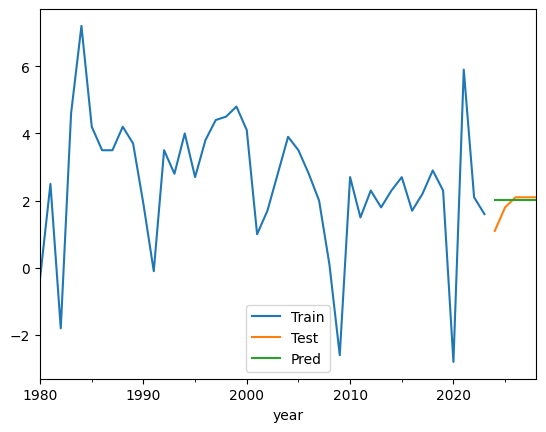

In [22]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_ses.plot(legend=True, label='Pred')

In [23]:
metrics_ses = metrics(test[country], pred_ses, 'Simple Exponential Smoothing')
metrics_ses

,Model,mae,rmse,mape
0,Simple Exponential Smoothing,0.27402,0.43181,21.46457


## 2.3 Sarimax

In [24]:
from pmdarima.arima import auto_arima

In [25]:
model_sarimax = auto_arima(
    train[country],
    m=1,
    test='adf',
    seasonal=False,
    stepwise=True,
    d=0,
    start_p=0,
    max_p=1,
    start_q=0,
    max_q=1,
)

In [26]:
pred_sarimax = model_sarimax.predict(test.shape[0])
pred_sarimax

2024-01-01    2.547727
2025-01-01    2.547727
2026-01-01    2.547727
2027-01-01    2.547727
2028-01-01    2.547727
Freq: AS-JAN, dtype: float64

<Axes: xlabel='year'>

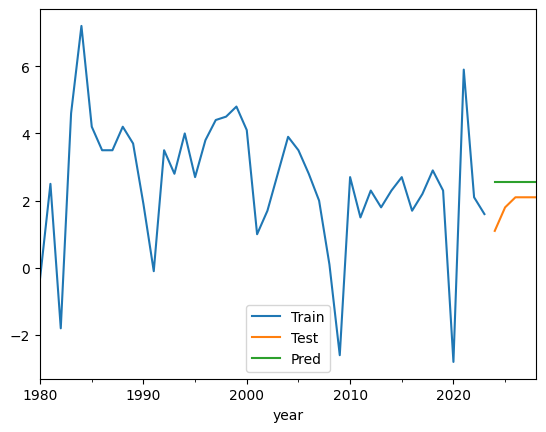

In [27]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_sarimax.plot(legend=True, label='Pred')

In [28]:
metrics_sarimax = metrics(test[country], pred_sarimax, 'sarimax')
metrics_sarimax

,Model,mae,rmse,mape
0,sarimax,0.70773,0.80702,47.4226


## 2.4 Prophet

In [29]:
from prophet import Prophet
from prophet.diagnostics import cross_validation

/home/lavino/Documentos/projetos_indicium/ds_desafio/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


15:38:41 - cmdstanpy - INFO - Chain [1] start processing
15:38:41 - cmdstanpy - INFO - Chain [1] done processing


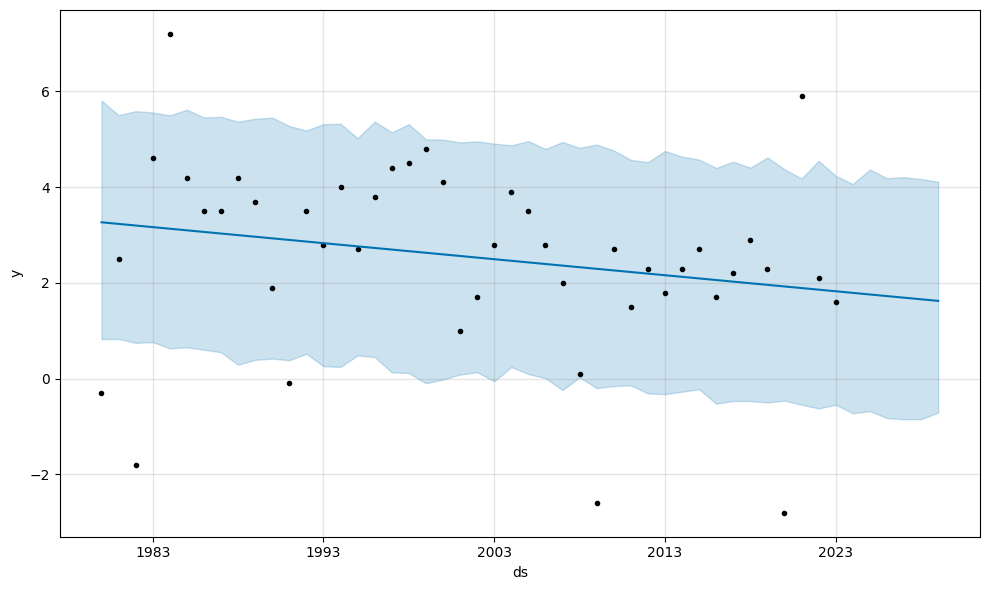

In [30]:

aux = train[[country]].copy()
aux['ds'] = aux.index
aux.rename(columns={country: 'y'}, inplace=True)
aux

# # Crie e ajuste o modelo
model_prophet = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0,
)
model_prophet.fit(aux)


future = model_prophet.make_future_dataframe(periods=6, freq='YS')  
forecast = model_prophet.predict(future)


model_prophet.plot(forecast);

<Axes: xlabel='year'>

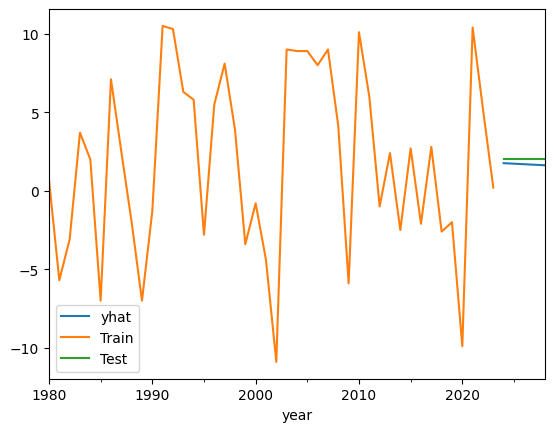

In [31]:
aux = forecast[['yhat']][-5:]
aux.index = test.index

aux.plot(legend=True, label='prophet');
train['Argentina'].plot(legend=True, label='Train')
test['Argentina'].plot(legend=True, label='Test')

In [32]:
metrics_prophet = metrics(test[country], aux['yhat'], 'prophet')
metrics_prophet

,Model,mae,rmse,mape
0,prophet,0.41149,0.4531,25.41923


In [33]:
df_cv = cross_validation(model_prophet, initial='365 days', parallel='processes', horizon='1825 days') 

15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing


15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing
15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1]

In [34]:
metrics_prophet_cv = metrics(df_cv.y, df_cv.yhat, 'Prophet CV')
metrics_prophet_cv

,Model,mae,rmse,mape
0,Prophet CV,2.03601,2.87564,315.90718


In [35]:
pd.concat([metrics_ses, metrics_sarimax, metrics_prophet, metrics_prophet_cv], axis=0)

,Model,mae,rmse,mape
0,Simple Exponential Smoothing,0.27402,0.43181,21.46457
0,sarimax,0.70773,0.80702,47.42260
0,prophet,0.41149,0.45310,25.41923
0,Prophet CV,2.03601,2.87564,315.90718


Numa primeira abordagem aos modelos, realizando testes com países aleátorios, foi identificado que o modelo simple exponential smoothing apresentou os melhores resultados.

# 3.0 Exogen variables

Teste da performace dos modelos utilizando valores de variaveis exogenas. como o grupo de país e o proprio crescimento mundial

## 3.1 auto arima

In [36]:
# exog = df1[['South America','World']]
# exog = df1[['South America']]
exog = df1[['World']]
train_exog = exog[:-test_years]
test_exog = exog[-test_years:]

In [37]:
model_auto_arima = auto_arima(
    y=train[country],
    X=train_exog,
    m=12,
    test='adf',
    seasonal=False,
    stepwise=True,
    d=0,
    start_p=0,
    max_p=1,
    start_q=0,
    max_q=1,
)

/home/lavino/Documentos/projetos_indicium/ds_desafio/venv/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [38]:
pred_auto_arima = model_auto_arima.predict(test.shape[0],X=test_exog)
pred_auto_arima

2024-01-01    1.962300
2025-01-01    2.245988
2026-01-01    2.291254
2027-01-01    2.216334
2028-01-01    2.130122
Freq: AS-JAN, dtype: float64

<Axes: xlabel='year'>

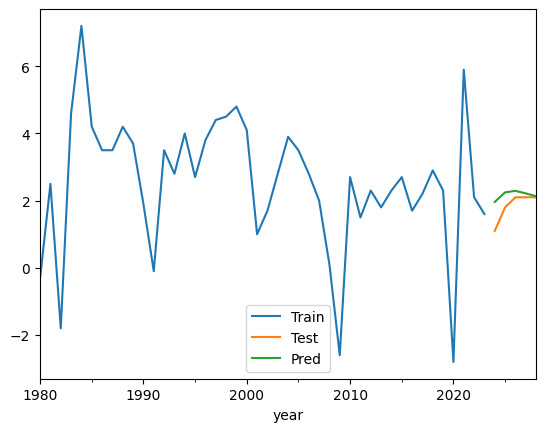

In [39]:
train[country].plot(legend=True, label='Train')
test[country].plot(legend=True, label='Test')
pred_auto_arima.plot(legend=True, label='Pred')

In [40]:
metrics_auto_arima = metrics(test[country], pred_auto_arima, 'auto_arima')
metrics_auto_arima

,Model,mae,rmse,mape
0,auto_arima,0.3292,0.44575,23.84989


## 3.2 Prophet

In [41]:
df2 = df1.copy()

In [42]:
df2['ds'] = df2.index

In [43]:
test_years = 5
train_pp = df2[:-test_years]
test_pp = df2[-test_years:]

15:38:44 - cmdstanpy - INFO - Chain [1] start processing
15:38:44 - cmdstanpy - INFO - Chain [1] done processing


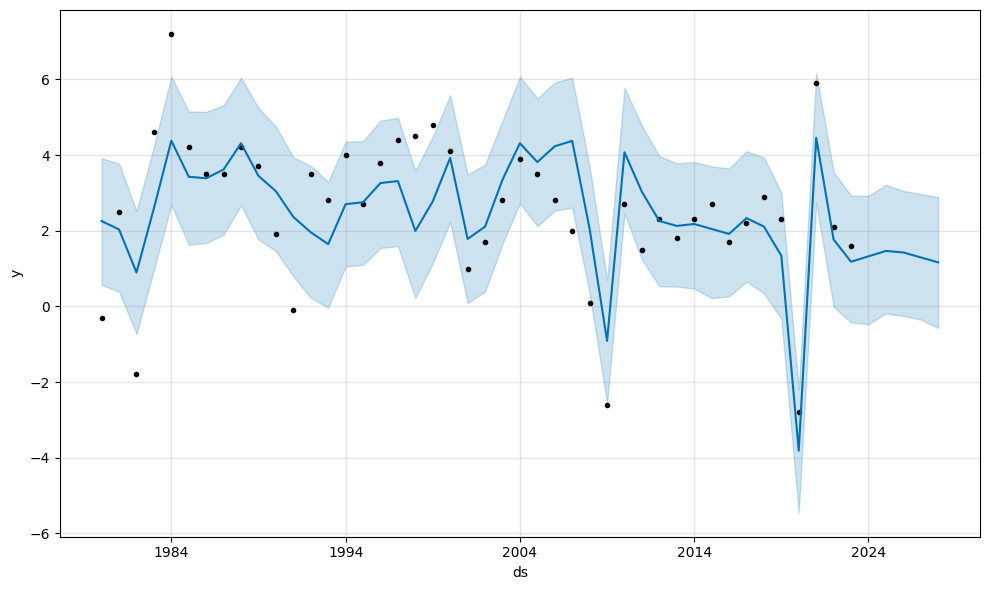

In [44]:

aux = pd.DataFrame()
aux['ds'] = df2['ds'].values
aux['y'] = df2[country].values
aux['World'] = df2['World'].values
# aux['South America'] = df2['South America'].values

test_years = 5
train_pp = aux[:-test_years]
test_pp = aux[-test_years:]

# Crie e ajuste o modelo
model_prophet = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0,
)
model_prophet.add_regressor('World')
# model_prophet.add_regressor('South America')
model_prophet.fit(train_pp)


future = model_prophet.make_future_dataframe(periods=test_years, freq='YS')  

# future = pd.concat([future, aux[['World','South America']]], axis=1)
future = pd.concat([future, aux[['World']]], axis=1)


forecast = model_prophet.predict(future)


model_prophet.plot(forecast);

<Axes: xlabel='year'>

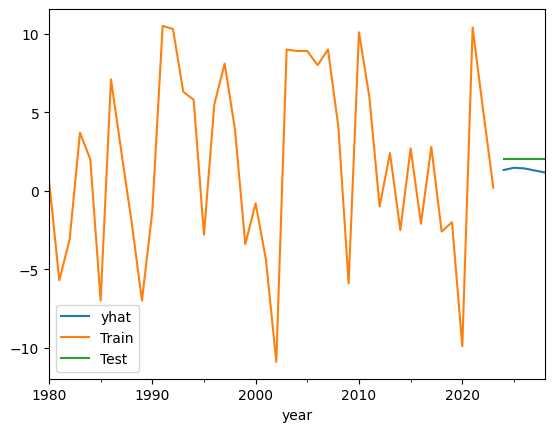

In [45]:
aux = forecast[['yhat']][-5:]
aux.index = test.index

aux.plot(legend=True, label='prophet');
train['Argentina'].plot(legend=True, label='Train')
test['Argentina'].plot(legend=True, label='Test')


In [46]:
metrics_prophet = metrics(test[country], aux['yhat'], 'prophet')
metrics_prophet

,Model,mae,rmse,mape
0,prophet,0.59486,0.65472,30.78452


In [47]:
from prophet.diagnostics import cross_validation

In [48]:
df_cv = cross_validation(model_prophet, initial='365 days', parallel='processes', horizon='1825 days') 

15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing


15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1]

In [49]:

metrics_prophet_cv = metrics(df_cv.y, df_cv.yhat, 'Prophet CV')
metrics_prophet_cv

,Model,mae,rmse,mape
0,Prophet CV,2.13831,2.89101,135.98402


In [50]:
pd.concat([metrics_auto_arima, metrics_prophet, metrics_prophet_cv], axis=0)

,Model,mae,rmse,mape
0,auto_arima,0.32920,0.44575,23.84989
0,prophet,0.59486,0.65472,30.78452
0,Prophet CV,2.13831,2.89101,135.98402


Embora tenha havido uma melhoria de desempenho para o método 'auto_arima', ele ainda apresenta um desempenho inferior em comparação com o método de simple exponential smoothing , quando este último é utilizado sem variáveis exógenas. Além disso, é importante notar que a variável exógena também está sujeita a previsões, o que torna o modelo inaplicável a si próprio.

# 4.0 All countrys

Agora, ao utilizar todos os países para treinar o modelo e avaliar sua performance geral, podemos observar o desempenho abrangente dos modelos em todas as séries.

In [51]:
df3 = df_raw.copy()

In [52]:
test_years = 5
train = df3[:-test_years]
test = df3[-test_years:]

## 4.1 auto_arima

In [53]:
df_pred_auto_arima = pd.DataFrame()
for country in df3.columns:
    
    model_auto_arima = auto_arima(
        train[country],
        m=1,
        test='adf',
        seasonal=False,
        stepwise=True,
        d=0,
        start_p=0,
        max_p=1,
        start_q=0,
        max_q=1,
    )
    
    pred_auto_arima = model_auto_arima.predict(test.shape[0])
    # df_pred_auto_arima[country] = pred_auto_arima
    df_pred_auto_arima = pd.concat([df_pred_auto_arima, pd.DataFrame(pred_auto_arima, columns=[country])], axis=1)

In [54]:
df_pred_auto_arima.index = test.index
df_pred_auto_arima

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
year,,,,,,,,,,,,,,,,,,,,,
2024-01-01,5.630638,3.738784,2.438544,0.552562,4.048752,3.889696,1.811364,3.734812,3.373297,3.560694,...,1.521734,4.033711,1.896477,1.834091,2.434091,2.086364,3.043934,2.840807,3.581051,3.361364
2025-01-01,5.630638,2.832769,2.385327,0.234865,4.359105,3.386085,1.811364,2.536149,3.478765,2.707185,...,1.693720,4.063896,1.896477,1.834091,2.434091,2.086364,3.122802,2.885693,3.570726,3.361364
2026-01-01,5.630638,2.832769,2.367787,0.099829,4.534628,3.386085,1.811364,1.722189,3.576063,3.230111,...,1.785656,4.089312,1.896477,1.834091,2.434091,2.086364,3.166017,2.927978,3.565100,3.361364
2027-01-01,5.630638,2.832769,2.362005,0.042432,4.633897,3.386085,1.811364,1.169464,3.665824,2.909726,...,1.834801,4.110713,1.896477,1.834091,2.434091,2.086364,3.189697,2.967814,3.562034,3.361364
2028-01-01,5.630638,2.832769,2.360099,0.018036,4.690040,3.386085,1.811364,0.794132,3.748632,3.106019,...,1.861072,4.128732,1.896477,1.834091,2.434091,2.086364,3.202672,3.005342,3.560364,3.361364


In [55]:

def metrics(y_true, y_pred,model_name, country):
    y_true = y_true.values
    y_pred = y_pred.values
    mae = round(mean_absolute_error(y_true, y_pred),5)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),5)
    mape = round(mean_absolute_percentage_error(y_true, y_pred),5)
    metrics = pd.DataFrame({'Country':country,'Model': model_name,'mae': mae, 'rmse': rmse, 'mape': mape}, index=[0])
    return metrics

In [56]:
df_metrics_auto_arima = pd.DataFrame()
for country in df_pred_auto_arima.columns:
    metrics_auto_arima = metrics(test[country], df_pred_auto_arima[country], 'auto_arima',country)
    df_metrics_auto_arima = pd.concat([df_metrics_auto_arima, metrics_auto_arima], axis=0)

In [57]:
df_metrics_auto_arima.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Macao SAR,auto_arima,20.56955,22.15063,348.18255
0,Guyana,auto_arima,20.33332,24.30388,562.48424
0,Libya,auto_arima,7.73532,8.93492,118.99196
0,Yemen,auto_arima,5.47565,5.73726,102.65598
0,Vietnam,auto_arima,5.34312,5.34976,79.09161
0,Mozambique,auto_arima,4.78591,6.59009,36.45871
0,Bosnia and Herzegovina,auto_arima,4.59277,4.81009,153.09224
0,Sierra Leone,auto_arima,4.34488,4.41786,91.76839
0,West Bank and Gaza,auto_arima,4.31275,4.32375,198.92813
0,Moldova,auto_arima,4.17665,4.19652,84.69639


<Axes: >

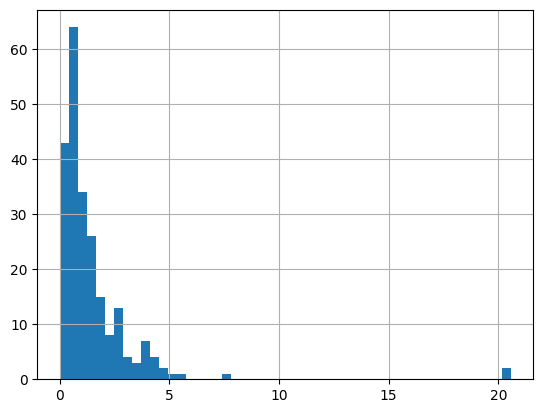

In [58]:
df_metrics_auto_arima['mae'].hist(bins=50)

In [59]:
df_metrics_auto_arima['mae'].agg(['mean','median','std'])

mean      1.482224
median    0.898300
std       2.156974
Name: mae, dtype: float64

## 4.2 Simple smothing

In [60]:
df_pred_ss = pd.DataFrame()
for country in df3.columns:

    # simple exponetial smooting
    model_ses = SimpleExpSmoothing(
        train[country],
        initialization_method='estimated',                              
    ).fit(smoothing_level=0.7, optimized=True)
# heuristic 
    pred_ses = model_ses.forecast(test.shape[0])
    df_pred_ss = pd.concat([df_pred_ss, pd.DataFrame(pred_ses, columns=[country])], axis=1)

In [61]:
df_metrics_ss = pd.DataFrame()
for country in df_pred_ss.columns:
    metrics_ss = metrics(test[country], df_pred_ss[country], 'simple smothing',country)
    df_metrics_ss = pd.concat([df_metrics_ss, metrics_ss], axis=0)

In [62]:
df_metrics_ss.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Macao SAR,simple smothing,27.73445,28.49951,605.59178
0,Guyana,simple smothing,24.49126,29.50096,687.01419
0,Sri Lanka,simple smothing,6.43806,6.46676,253.37240
0,Ukraine,simple smothing,6.20001,6.20001,295.87922
0,Caribbean,simple smothing,6.14876,6.39390,203.96997
0,Yemen,simple smothing,5.65466,5.92581,105.83273
0,Mozambique,simple smothing,5.15503,6.85629,41.29928
0,Libya,simple smothing,4.61330,4.88763,86.75301
0,The Bahamas,simple smothing,4.14862,4.15007,260.88570
0,Ireland,simple smothing,4.14520,4.16561,128.10331


<Axes: >

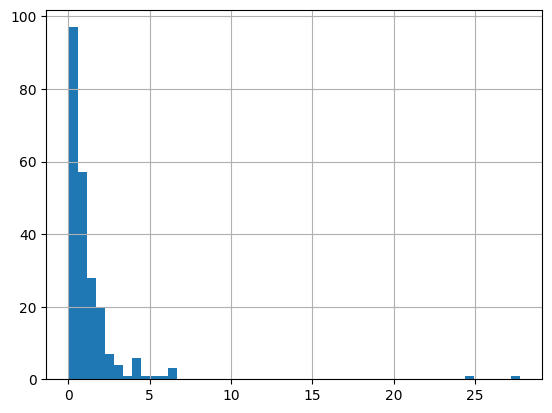

In [63]:
df_metrics_ss['mae'].hist(bins=50)

In [64]:
df_metrics_ss['mae'].agg(['mean','median','std'])

mean      1.288721
median    0.697400
std       2.617642
Name: mae, dtype: float64

## 4.3 Prophet

In [65]:

df_pred_prophet = pd.DataFrame()

for country in df3.columns:
    aux = train[[country]].copy()
    aux['ds'] = aux.index
    aux.rename(columns={country: 'y'}, inplace=True)
    aux

    # # Crie e ajuste o modelo
    model_prophet = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0,
    )
    model_prophet.fit(aux)


    future = model_prophet.make_future_dataframe(periods=test.shape[0], freq='YS')  
    forecast = model_prophet.predict(future)
    df_pred_prophet = pd.concat([df_pred_prophet, pd.DataFrame(forecast[['yhat']][-5:].values, columns=[country])], axis=1)

15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing


15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1]

In [66]:
df_metrics_prophet = pd.DataFrame()
for country in df_pred_prophet.columns:
    metrics_prophet = metrics(test[country], df_pred_prophet[country], 'phophet',country)
    df_metrics_prophet = pd.concat([df_metrics_prophet, metrics_prophet], axis=0)

In [67]:
df_metrics_prophet.sort_values(by='mae', ascending=False).head(20)

,Country,Model,mae,rmse,mape
0,Guyana,phophet,18.71707,19.18704,317.52606
0,Equatorial Guinea,phophet,7.85506,8.90264,437.69437
0,Azerbaijan,phophet,7.60160,7.62054,296.96489
0,Venezuela,phophet,6.77428,7.02723,706.45319
0,Tajikistan,phophet,6.72677,6.75902,165.04951
0,Macao SAR,phophet,6.36106,8.83559,71.30168
0,Iraq,phophet,6.20063,6.21738,254.36364
0,Republic of South Sudan,phophet,6.17700,6.22513,137.60980
0,Turkmenistan,phophet,6.00388,6.01382,260.30076
0,Qatar,phophet,6.00219,6.02448,215.54076


<Axes: >

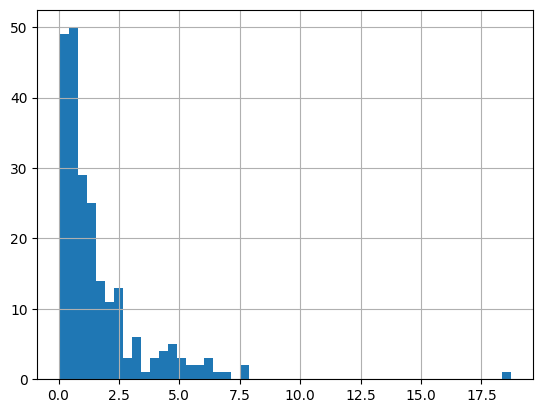

In [68]:
df_metrics_prophet['mae'].hist(bins=50)

## 4.4 comparison

### 4.4.1 MAE

In [69]:
df_final_metrics = pd.DataFrame()

metric = 'mae'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add auto_arima
df_final_metrics = pd.concat([df_final_metrics, df_metrics_auto_arima[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','auto_arima']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,1.642346,1.003945,1.961299,0.055700,18.717070,1.194206
simple_smoothing,1.288721,0.697400,2.617642,0.019480,27.734450,2.031194
auto_arima,1.482224,0.898300,2.156974,0.000000,20.569550,1.455228


### 4.4.2 RMSE

In [70]:
df_final_metrics = pd.DataFrame()

metric = 'rmse'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add auto_arima
df_final_metrics = pd.concat([df_final_metrics, df_metrics_auto_arima[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','auto_arima']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,1.726555,1.032785,2.052355,0.080230,19.187040,1.188699
simple_smoothing,1.379727,0.745805,2.881058,0.019480,29.500960,2.088136
auto_arima,1.598677,0.971070,2.431278,0.000000,24.303880,1.520806


### 4.4.3 MAPE

In [71]:
df_final_metrics = pd.DataFrame()

metric = 'mape'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
df_final_metrics = pd.concat([df_final_metrics, df_metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
df_final_metrics = pd.concat([df_final_metrics, df_metrics_ss[metric].agg([statistics])], axis=1)

# add auto_arima
df_final_metrics = pd.concat([df_final_metrics, df_metrics_auto_arima[metric].agg([statistics])], axis=1)

df_final_metrics.columns = ['prophet','simple_smoothing','auto_arima']

df_final_metrics = df_final_metrics.T

df_final_metrics['cv'] = df_final_metrics['std'] / df_final_metrics['mean']  

df_final_metrics.style.highlight_min(color='lightgreen', axis=0)
# df_final_metrics

,mean,median,std,min,max,cv
prophet,57.816669,32.222000,76.873557,0.936100,706.453190,1.329609
simple_smoothing,46.013746,22.037015,82.442300,0.695720,687.014190,1.791688
auto_arima,46.247781,31.770445,54.678141,0.000000,562.484240,1.182287


Foi observado que o simple exponential smoothing perfomou melhor e mais estável que os demais modelos

# 5.0 cross validation

Será aplicada a validação cruzada para verificar a estabilidade dos modelo auto_arima e simple exponential smoothing

## 5.1 Simple smothing

mean mae for all countrys: 3.7541548752331964
median mae for all countrys 3.0548487775568036
std mae for all countrys: 2.375351945163901
max mae for all countrys: 21.960004251189652
min mae for all countrys: 1.0535072712366245
CV mae for all countrys: 0.6327261458589536


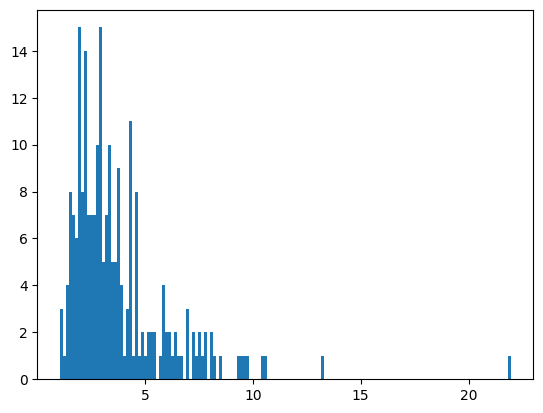

In [72]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Crie um DataFrame vazio para armazenar as métricas finais

df_final_metrics_cv = pd.DataFrame()

# Defina a métrica que você está calculando (por exemplo, 'mae')
metric = 'mae'

# Lista das estatísticas que você deseja calcular
statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max'
]

# Crie um objeto TimeSeriesSplit com o número de splits desejado
n_splits = 5  # Número de folds para cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop através das divisões da avaliação cruzada
for country in df3.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train[country]):
        train_data = train[country].iloc[train_idx]
        test_data = train[country].iloc[test_idx]
        
        # Ajuste o modelo Simple Exponential Smoothing (SES)
        model_ses = SimpleExpSmoothing(train_data, initialization_method='estimated').fit()
        
        # Faça previsões no conjunto de teste
        forecast = model_ses.forecast(len(test_data))
        
        # Calcule a métrica desejada (MAE)
        mae = mean_absolute_error(test_data, forecast)
        
        # Adicione o MAE à lista de métricas
        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)
    df_final_metrics_cv = pd.concat([df_final_metrics_cv, final_metrics_cv], axis=1)


aux = df_final_metrics_cv.mean()

print("mean mae for all countrys:",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys:",aux.values.std())
print("max mae for all countrys:",aux.values.max())
print("min mae for all countrys:",aux.values.min())
print("CV mae for all countrys:",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=150);

## 5.2 Auto arima

mean mae for all countrys: 3.6185197164891822
median mae for all countrys 3.022688031090322
std mae for all countrys: 2.2329373541431314
max mae for all countrys: 19.562123519079215
min mae for all countrys: 1.0991255411988314
CV mae for all countrys: 0.6170858608197961


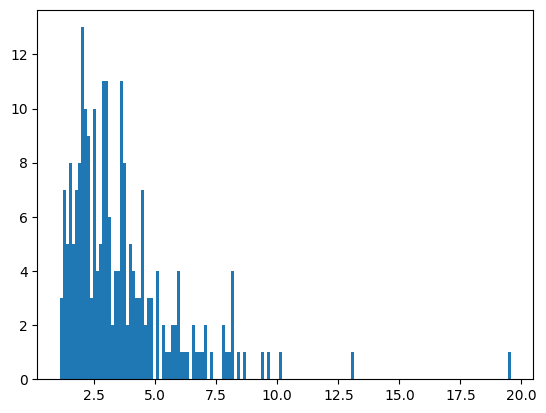

In [73]:
# Crie um DataFrame vazio para armazenar as previsões do SARIMA
df_final_metrics_cv = pd.DataFrame()

# Defina o número de splits desejado para a avaliação cruzada
n_splits = 5

# Crie um objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop através das divisões da avaliação cruzada

    
    # Loop através das colunas (países)
for country in df3.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train[country]):
        train_data = train[country].iloc[train_idx]
        test_data = train[country].iloc[test_idx]
        model_auto_arima = auto_arima(
            train_data,
            m=1,
            test='adf',
            seasonal=False,
            stepwise=True,
            d=0,
            start_p=0,
            max_p=1,
            start_q=0,
            max_q=1,
        )
            
            
        pred_auto_arima = model_auto_arima.predict(len(test_data))

        mae = mean_absolute_error(test_data, pred_auto_arima)

        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)

    df_final_metrics_cv = pd.concat([df_final_metrics_cv, final_metrics_cv], axis=1)

aux = df_final_metrics_cv.mean()

print("mean mae for all countrys:",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys:",aux.values.std())
print("max mae for all countrys:",aux.values.max())
print("min mae for all countrys:",aux.values.min())
print("CV mae for all countrys:",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=150);


# 6.0 Fine tuning

Tanto o simple exponential smoothing quanto o auto arima apresentaram resultados muito próximos, com o simple exponential smoothing apresentando uma leve vantagem. Portanto será realizado o fine tuning apenas para o simple exponential smoothing, pois além da vantagem de performace, o modelo é mais simples e mais rápido de ser treinado.

## 6.1 Simple smothing

In [74]:
from sklearn.model_selection import  TimeSeriesSplit, ParameterGrid

In [75]:
tscv = TimeSeriesSplit(n_splits=n_splits)
df_countrys_paramns = pd.DataFrame()

param_grid = {
    'smoothing_level': list(np.arange(0.1, 1.1, 0.1)), 
    'initialization_method': ['estimated', 'heuristic'],
}

grid = ParameterGrid(param_grid)


for country in df3.columns:

    final_metrics_cv = pd.DataFrame()
    best_mae = float('inf')
    best_params = None
    std_mae = None

    for params in grid:
        for train_idx, test_idx in tscv.split(train[country]):
            train_data = train[country].iloc[train_idx]
            test_data = train[country].iloc[test_idx]
                
                # Ajuste o modelo Simple Exponential Smoothing (SES)
            model_ses = SimpleExpSmoothing(
                train[country],
                initialization_method=params['initialization_method'],                              
            ).fit(
                smoothing_level=params['smoothing_level'], 
                optimized=False
            )
                
                # Faça previsões no conjunto de teste
            forecast = model_ses.forecast(len(test_data))
                
                # Calcule a métrica desejada (MAE)
            mae = mean_absolute_error(test_data, forecast)
                
                # Adicione o MAE à lista de métricas
            final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)

        mean_mae_cv = final_metrics_cv.values.mean()
        std_mae_cv = final_metrics_cv.values.std()

        if mean_mae_cv < best_mae:
            best_mae = mean_mae_cv
            best_params = params
            std_mae = std_mae_cv
        
            
        # create dataframe with mean mae, country and best_paramns
    df_countrys_paramns = pd.concat([
        df_countrys_paramns, 
        pd.DataFrame({
            'country': [country], 
            'mean_mae': [best_mae], 
            'std_mae': [std_mae],
            'best_params': [best_params]})
        ], 
        ignore_index=True
    )

mean mae for all countrys: 3.3249841518204786
median mae for all countrys: 2.674279170759829
std mae for all countrys: 2.3456604611786154
max mae for all countrys: 19.461103887247873
min mae for all countrys: 0.9728609536836569
CV mae for all countrys: 0.7054651553434717


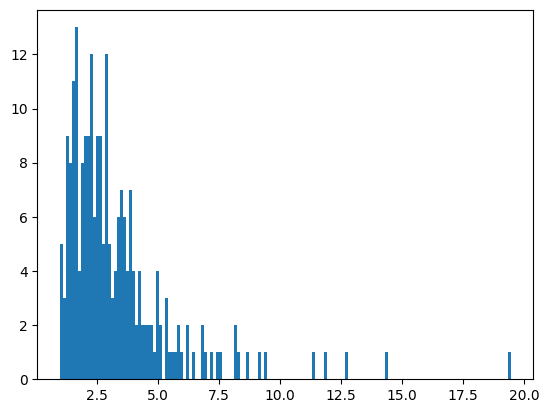

In [76]:
print("mean mae for all countrys:",df_countrys_paramns['mean_mae'].mean())
print("median mae for all countrys:",np.median(df_countrys_paramns['mean_mae']))
print("std mae for all countrys:",df_countrys_paramns['mean_mae'].std())
print("max mae for all countrys:",df_countrys_paramns['mean_mae'].max())
print("min mae for all countrys:",df_countrys_paramns['mean_mae'].min())
print("CV mae for all countrys:",df_countrys_paramns['mean_mae'].std() / df_countrys_paramns['mean_mae'].mean())
plt.hist(df_countrys_paramns['mean_mae'], bins=150);

# 7.0 Predictions

As previsãoes serão feitas no notebook "desafio_ds_v01_03_predict.ipynb" com os dados de paramentros calculados

## 7.1 Save to csv

In [83]:
df_countrys_paramns.to_csv(path + 'data/df_countrys_paramns.csv',index=False)